In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d.axes3d import get_test_data
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pymongo
from pymongo import MongoClient
import datetime
import warnings
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [54]:
pip install pymongo

Note: you may need to restart the kernel to use updated packages.


In [55]:
timeSeriesData = pd.DataFrame(columns=['symbol','date','cur_price','trade_quantity','updown_rate'])
timeSeriesCountData = pd.DataFrame(columns=['symbol','date','count'])

In [56]:

client = MongoClient('mongodb://127.0.0.1:27017/')
db = client['mph']
collection_price = db['crypto_prices']
collection_agg = db['token_aggs']

In [57]:
price_data = collection_price.find({'symbol':'LINK'})
agg_data = collection_agg.find({'symbol':'LINK'})
#data = collection.find()
print(agg_data)
index = 0

In [58]:
for price_detail in price_data:
    timeSeriesData.loc[index, 'symbol'] = price_detail['symbol']
    timeSeriesData.loc[index,'date']= price_detail['date']
    timeSeriesData.loc[index, 'cur_price'] = price_detail['cur_price']
    timeSeriesData.loc[index, 'trade_quantity'] = price_detail['trade_quantity']
    timeSeriesData.loc[index, 'updown_rate'] = price_detail['updown_rate']
    index+=1

index1 = 0

for agg_detail in agg_data:
    timeSeriesCountData.loc[index1, 'symbol'] = agg_detail['symbol']
    timeSeriesCountData.loc[index1,'date']= datetime.datetime.strptime(str(agg_detail['date']),'%Y%m%d')
    timeSeriesCountData.loc[index1, 'count'] = agg_detail['count']/18 # nomarlization
    index1+=1


timeSeriesData = timeSeriesData.sort_values(['date'])
timeSeriesCountData = timeSeriesCountData.sort_values(['date'])

In [59]:
print(timeSeriesData)
print(timeSeriesCountData)

    symbol                 date cur_price trade_quantity updown_rate
670   LINK  2018-02-02 00:00:00      0.49          21740        -4.1
669   LINK  2018-02-03 00:00:00      0.51          12690        3.48
668   LINK  2018-02-04 00:00:00      0.44          19420      -14.26
667   LINK  2018-02-05 00:00:00       0.4          17420       -8.82
666   LINK  2018-02-06 00:00:00      0.42          42930        6.22
..     ...                  ...       ...            ...         ...
4     LINK  2019-11-30 00:00:00      2.24        3400000       -4.28
3     LINK  2019-12-01 00:00:00      2.16        4080000       -3.38
2     LINK  2019-12-02 00:00:00      2.09        4000000       -3.14
1     LINK  2019-12-03 00:00:00      2.12        4510000         1.5
0     LINK  2019-12-04 00:00:00      2.08        6300000       -2.27

[671 rows x 5 columns]
   symbol                 date      count
0    LINK  2017-12-31 00:00:00  0.0555556
1    LINK  2018-02-17 00:00:00  0.0555556
2    LINK  2018-02-28 

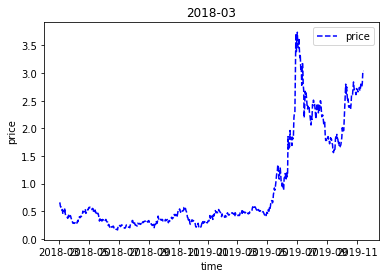

In [60]:
startDate1 = "2018-03-02"
endDate1 = "2019-11-15"

startDate = datetime.datetime.strptime(startDate1,"%Y-%m-%d")
endDate = datetime.datetime.strptime(endDate1,"%Y-%m-%d")

monthDate = startDate +pd.DateOffset(months=3)
###########################################################
# train을 위한 시계열 범위를 19년 4월 부터 6월 31일까지 1개 분기로 정함
###########################################################
timeSeriesData1 = timeSeriesData.loc[(timeSeriesData['date'] >= startDate) & (timeSeriesData['date'] <= endDate), :]
timeSeriesCountData1 = timeSeriesCountData.loc[(timeSeriesCountData['date'] >= startDate) & (timeSeriesCountData['date'] <= monthDate), :]

plt.plot(timeSeriesData1['date'].values, timeSeriesData1['cur_price'].values,'b--')
#plt.plot(timeSeriesCountData1['date'].values, timeSeriesCountData1['count'].values, 'ro')
plt.title(startDate.strftime('%Y-%m'))
plt.xlabel('time')
plt.ylabel('price')
plt.legend(['price','lift','downhill'])
plt.show()

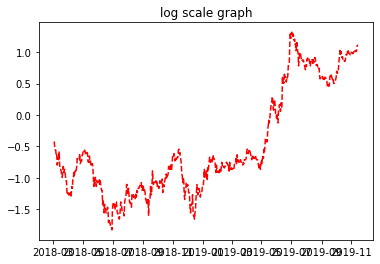

In [61]:
timeSeriesData1['log_price'] = np.log(np.array(timeSeriesData1['cur_price'],dtype=np.float32))

plt.plot(timeSeriesData1['date'].values, timeSeriesData1['log_price'].values, 'r--')
plt.title('log scale graph')
plt.show()

<Figure size 432x288 with 0 Axes>

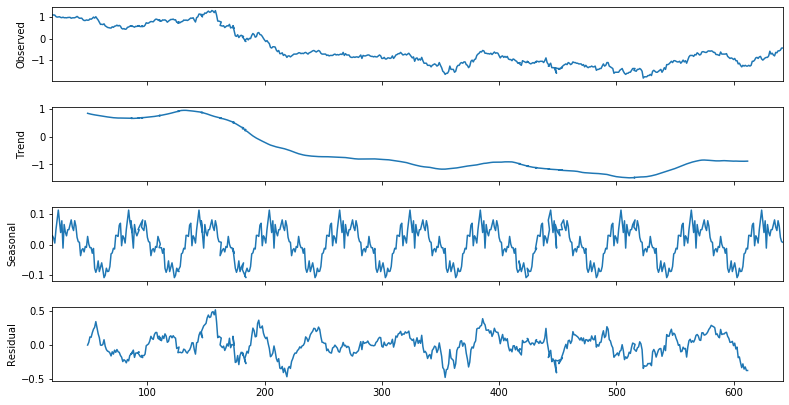

In [62]:
decompostion = seasonal_decompose(timeSeriesData1.log_price,freq=60)
fig = plt.figure()
fig = decompostion.plot()
fig.set_size_inches(12,6)

In [63]:
# 0 과 2 사이에서  p, d, q를 선언  
p = d= q = range(0,2)

In [64]:
# 가능한 모든 다른 조합을 만들어 냄 
pdq = list(itertools.product(p,d,q))

In [65]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [66]:
seasonal_pdq = [(x[0],x[1],x[2],60) for x in list(itertools.product(p,d,q))]

In [67]:
seasonal_pdq

[(0, 0, 0, 60),
 (0, 0, 1, 60),
 (0, 1, 0, 60),
 (0, 1, 1, 60),
 (1, 0, 0, 60),
 (1, 0, 1, 60),
 (1, 1, 0, 60),
 (1, 1, 1, 60)]

In [68]:
warnings.filterwarnings("ignore")

In [69]:
for param in pdq :
    for param_seasonal in seasonal_pdq :
        try :
            mod = sm.tsa.statespace.SARIMAX(timeSeriesData1.log_price,
                                           order = param ,
                                           trend = 't',
                                           seasonal_order = param_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA {} x {} - AIC:{}'.format(param,param_seasonal,results.aic))
        except : 
            print('exception')
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 60) - AIC:1741.2933915380856
ARIMA (0, 0, 0) x (0, 0, 1, 60) - AIC:1289.0313998389074
ARIMA (0, 0, 0) x (0, 1, 0, 60) - AIC:894.5169460571072
ARIMA (0, 0, 0) x (0, 1, 1, 60) - AIC:616.0060839275558
ARIMA (0, 0, 0) x (1, 0, 0, 60) - AIC:876.6406102233454
ARIMA (0, 0, 0) x (1, 0, 1, 60) - AIC:733.9966609596238
ARIMA (0, 0, 0) x (1, 1, 0, 60) - AIC:770.3285319517117
ARIMA (0, 0, 0) x (1, 1, 1, 60) - AIC:706.3193234366543
ARIMA (0, 0, 1) x (0, 0, 0, 60) - AIC:938.7765535915235
ARIMA (0, 0, 1) x (0, 0, 1, 60) - AIC:587.0073626140729
ARIMA (0, 0, 1) x (0, 1, 0, 60) - AIC:243.22872238646252
ARIMA (0, 0, 1) x (0, 1, 1, 60) - AIC:24.52695189995977
ARIMA (0, 0, 1) x (1, 0, 0, 60) - AIC:218.64336212871817
ARIMA (0, 0, 1) x (1, 0, 1, 60) - AIC:47.27155080498375
ARIMA (0, 0, 1) x (1, 1, 0, 60) - AIC:134.28535435673834
ARIMA (0, 0, 1) x (1, 1, 1, 60) - AIC:20.80535484520971
ARIMA (0, 1, 0) x (0, 0, 0, 60) - AIC:-1439.07549014626
ARIMA (0, 1, 0) x (0, 0, 1, 60) - AIC:-1297

In [80]:
mod = sm.tsa.statespace.SARIMAX(timeSeriesData1.log_price,
                               order=(0,0,1),
                               seasonal_order=(1,1,1,60),
                               trend='t',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          log_price   No. Observations:                  624
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 60)   Log Likelihood                  -5.403
Date:                            Thu, 19 Dec 2019   AIC                             20.805
Time:                                    22:29:12   BIC                             41.898
Sample:                                         0   HQIC                            29.081
                                            - 624                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0008   4.39e-05     17.353      0.000       0.001       0.001
ma.L1          0.8437      0.030   

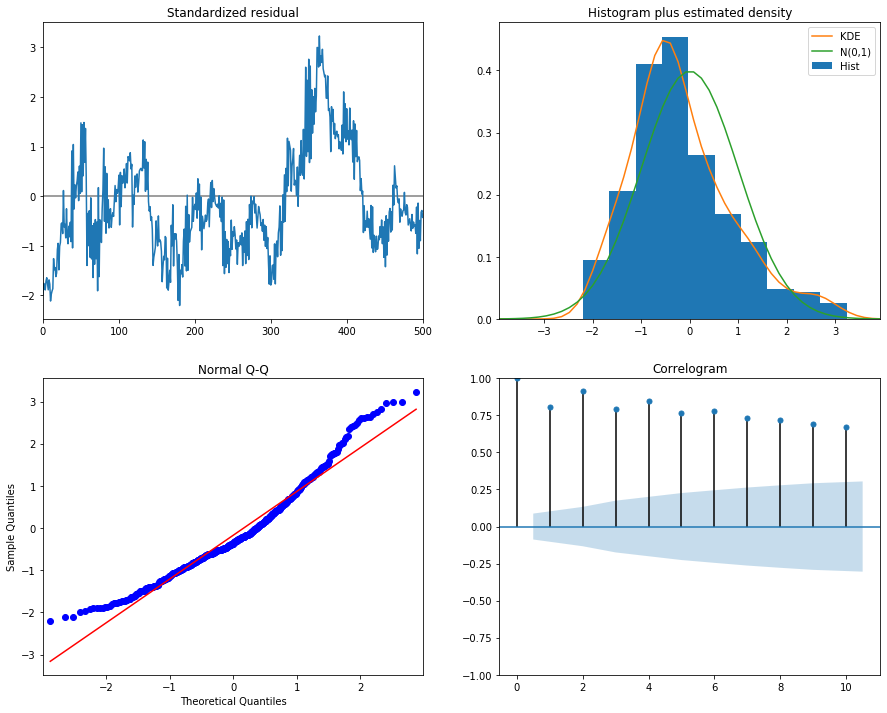

In [81]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

In [82]:
timeSeriesData1['forecast'] = results.predict(start=503, end=643,dynamic = True)-2.0

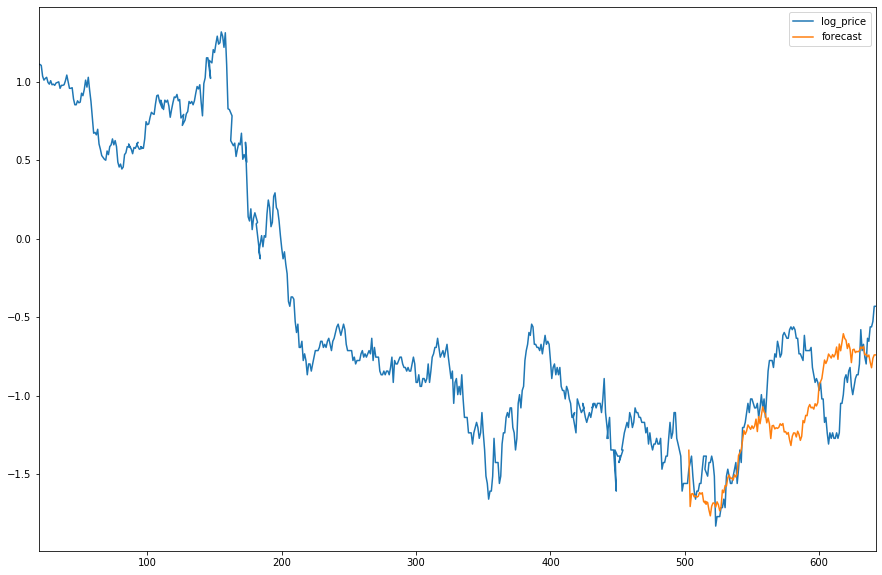

In [83]:
timeSeriesData1[['log_price','forecast']].plot(figsize=(15,10))